In [1]:
!gdown --id 1Cjam10hdTLQZYuRPggMV2DcilwiF0Um_

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Cjam10hdTLQZYuRPggMV2DcilwiF0Um_
To: /content/ProductsSince2021.csv
100% 186M/186M [00:01<00:00, 136MB/s]


In [2]:
!wget 'https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKtc-hinted.zip'
!mkdir /tmp/fonts
!unzip -o NotoSansCJKtc-hinted.zip -d /tmp/fonts/
!mv /tmp/fonts/NotoSansMonoCJKtc-Regular.otf /usr/share/fonts/truetype/NotoSansMonoCJKtc-Regular.otf -f
!rm -rf /tmp/fonts
!rm NotoSansCJKtc-hinted.zip

--2022-05-31 10:56:56--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKtc-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 173.194.218.128, 2607:f8b0:400c:c14::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|173.194.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121247366 (116M) [application/zip]
Saving to: ‘NotoSansCJKtc-hinted.zip’

NotoSansCJKtc-hinte 100%[===================>] 115.63M   152MB/s    in 0.8s    

2022-05-31 10:56:57 (152 MB/s) - ‘NotoSansCJKtc-hinted.zip’ saved [121247366/121247366]

Archive:  NotoSansCJKtc-hinted.zip
  inflating: /tmp/fonts/LICENSE_OFL.txt  
  inflating: /tmp/fonts/NotoSansCJKtc-Black.otf  
  inflating: /tmp/fonts/NotoSansCJKtc-Bold.otf  
  inflating: /tmp/fonts/NotoSansCJKtc-DemiLight.otf  
  inflating: /tmp/fonts/NotoSansCJKtc-Light.otf  
  inflating: /tmp/fonts/NotoSansCJKtc-Medium.otf  
  inflating

In [3]:
import pandas as pd
import numpy as np
import ast
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [4]:
import matplotlib.pyplot as plt 
import seaborn as sns

In [5]:
df = pd.read_csv('/content/ProductsSince2021.csv',low_memory=False)

In [6]:
strList_cols = ['Feature','Material','Category']

In [7]:
def str_to_ls(clothing_list):
    return list(map(str.strip, clothing_list.strip('][').replace("'", '').split(','))) 
def get_df_P(time_type, time, time_range = 4):
    #filtering
    day_ls = sorted(df.CreateDate.unique())
    day1 = np.searchsorted(day_ls, time, side = 'right')-1
    day0 = day1 - time_range
    if time_type == 'new':
        data0 = df[df['CreateDate'] == day_ls[day0]]
        data1 = df[df['CreateDate'] == day_ls[day1]]
        data = data1[~data1['Url'].isin(data0.Url)]
    elif time_type == 'market':
        data = df[df['CreateDate'] == day_ls[day1]]
        day0 = day1 - 1
    elif time_type == 'market_with_time_range':
        df_ls = []
        for i in range(day0,day1+1):
            df_ls.append(df[df['CreateDate'] == day_ls[i]])
        data = pd.concat(df_ls)
        data = data.drop_duplicates(subset='Url', keep="last")

    for col in strList_cols:
        data[col] = data[col].fillna('[\'nan\']')
        data[col] = data[col].apply(lambda x:str_to_ls(x))

    data['AllColorRatio'] = data['AllColorRatio'].fillna("'{}'")
    data['AllColorRatio'] = data['AllColorRatio'].apply(ast.literal_eval)
    data['AllColorRatio'] = data['AllColorRatio'].apply(lambda d: dict([a, float(x[:-1])] for a, x in d.items()) if type(d) is dict else 'nan')
    data['MainColor'] = data['AllColorRatio'].apply(lambda d: max(d, key=d.get) if type(d) is dict else 'nan')
    prev_name = ''
    prev_num = ''
    url_list = []
    color_list = []
    ls = []
    last = 0
    for name, url, maincolor, num in zip(data['Name'],data['Url'],data['MainColor'],data['Material']):
        if name != prev_name or prev_num!= num:
            prev_name = name
            prev_num = num
            url_list.append(url)
            color_list.append(list(set(ls)))
            ls = [maincolor]
        else:   
            ls.append(maincolor)
    color_list.append(list(set(ls)))
    df_P = data[data['Url'].isin(url_list)]
    df_P['AllMainColor'] = color_list[1:]
    # df_P['色系'] = df_P['MainColor']
    return df_P,[day_ls[day0],day_ls[day1]]

In [8]:
# 件數佔比圖Settings
# Selecting data - Porpotion
def proportion_data(df_P,proportion_time_range,proportion_filter,proportion_groupBy):
    filter_bool = np.array([True]*len(df_P))

    for key, value in proportion_filter.items():
        if type(value) == list:
            or_filter_bool = np.array([False]*len(df_P))
            for i in value:
                or_filter_bool = np.logical_or(or_filter_bool, df_P[key].apply(lambda x: True if i in x else False))
            filter_bool = np.logical_and(filter_bool, or_filter_bool) 
        else:
            filter_bool = np.logical_and(filter_bool, df_P[key].apply(lambda x: True if value in x else False))
        
    if len(proportion_filter) == 0:
        filter_bool = np.array([True]*len(df_P))

    df_P = df_P[filter_bool]
    col_name = proportion_time_range[0] +'-'+ proportion_time_range[1]
    if type(df_P[proportion_groupBy].reset_index()[proportion_groupBy][0]) == list:
        dic = {}
        if proportion_groupBy == 'Material':
            for ls in df_P[proportion_groupBy]:
                for i in ls:
                    if i in dic:
                        dic[i] += 1/len(ls)
                    else:
                        dic[i] = 1/len(ls)
        else:
            for ls in df_P[proportion_groupBy]:
                for i in ls:
                    if i in dic:
                        dic[i] += 1
                    else:
                        dic[i] = 1

        df = pd.DataFrame.from_dict(dic, orient='index').set_axis([col_name], axis=1, inplace=False).sort_values([col_name], ascending=False)
    else:
        df = df_P[['Url',proportion_groupBy]].groupby([proportion_groupBy]).count().sort_values(['Url'], ascending=False).set_axis([col_name], axis=1, inplace=False)

    return df,df_P

In [9]:
def colorStyle(x):
    if x == 'Red': return'暖色系'
    elif x == 'Yellow': return'暖色系'
    elif x == 'Pink': return'暖色系'
    elif x == 'Orange': return'暖色系'
    elif x == 'Fuchsia': return'暖色系'
    elif x == 'Khaki': return'暖色系'
    elif x == 'Green': return'冷色系'
    elif x == 'Blue': return'冷色系'
    elif x == 'Purple': return'冷色系'
    elif x == 'Lightcyan': return'冷色系'
    elif x == 'Black': return'中性色系'
    elif x == 'White': return'中性色系'
    elif x == 'Gray': return'中性色系'
    elif x == 'Brown': return'中性色系'
    else: return 'nan'

def get_colorStyle(ls):
    result_ls = []
    for color in ls:
        result_ls.append(colorStyle(color))
    return list(set(result_ls))

In [10]:
def get_proportion_data(time_type, time, time_range, proportion_filter, proportion_groupBy):
    df_P,proportion_time_range = get_df_P(time_type, time, time_range)
    df_P['色系'] = df_P['AllMainColor'].apply(lambda x: get_colorStyle(x))
    return proportion_data(df_P,proportion_time_range,proportion_filter,proportion_groupBy)

#圓餅圖資料

In [11]:
# Settings
# sport = 'Training & Gym'
time_type = 'market' # market
time = '2022-05-28'
time_range = 4 # week 幾周量的新品
proportion_filter = {'色系':'暖色系'}#{'Feature':'結構性透氣'}
proportion_groupBy = '色系' # Brand Material 'Category' 'AllMainColor' '色系'

result, df_filtered = get_proportion_data(time_type, time, time_range, proportion_filter, proportion_groupBy)
df_filtered.head(2)

,Unnamed: 0,Name,Url,CreateDate,ModifiedDate,Price,Gender,AverageRating,ReviewNumber,Brand,...,NewArrival,Category,Sports,Material,Feature,AllColorRatio,ColorCode,MainColor,AllMainColor,色系
371753,371753,Triumph Hoodie,https://athleta.gap.com/browse/product.do?pid=...,2022-05-08,2022-05-08,108.0,women,NaN,NaN,athleta,...,False,[Hoodies],"['Climbing', 'Training & Gym', 'Hiking & Trail']","[Cotton, Spandex]","[涼爽透氣, 環保訴求]","{'Blue': 0.0, 'Brown': 0.11365481409319694, 'P...","['#FF00FF', '#721E60', '#723665']",Fuchsia,[Fuchsia],[暖色系]
371758,371758,Ultra High Rise Elation 7&#34 Short,https://athleta.gap.com/browse/product.do?pid=...,2022-05-08,2022-05-08,59.0,women,NaN,NaN,athleta,...,False,[Shorts],"['Yoga', 'Training & Gym']","[Nylon/Lycra, WICKING: Pulls sweat away from t...","[抗紫外線, 涼爽透氣, 單向導溼快乾, 提升運動效能設計, 結構性透氣]","{'Green': 21.7649197763738, 'Fuchsia': 0.0, 'G...","['#A8A800', '#8E843C']",Khaki,"[nan, Khaki]","[nan, 暖色系]"


#折線圖資料

In [12]:
def get_line_data(time_type,time_range,times,last_time,proportion_filter,proportion_groupBy):
    df_ls = []
    time_ls = []
    day_ls = sorted(df.CreateDate.unique())
    day1 = np.searchsorted(day_ls, last_time, side = 'right')-1
    for i in range(times-1,-1,-1):
        time_ls.append(day_ls[day1 - (i* time_range)])

    for time in time_ls:
        result, df_P = get_proportion_data(time_type, time, time_range, proportion_filter, proportion_groupBy)
        df_ls.append(result)

    return pd.concat(df_ls, axis=1).fillna(0)

In [13]:
def get_line_data(time_type,time_range,times,last_time,proportion_filter,proportion_groupBy):
    df_ls = []
    time_ls = []
    day_ls = sorted(df.CreateDate.unique())
    day1 = np.searchsorted(day_ls, last_time, side = 'right')-1
    for i in range(times-1,-1,-1):
        time_ls.append(day_ls[day1 - (i* time_range)])

    for time in time_ls:
        result, df_P = get_proportion_data(time_type, time, time_range, proportion_filter, proportion_groupBy)
        df_ls.append(result)

    return pd.concat(df_ls, axis=1).fillna(0)

# 畫圓餅圖 長條圖

In [14]:
# 圓餅圖
def piechart(data,category,amount):
  plt.figure(figsize=(12,6))    # 顯示圖框架大小

  labels = data[category]    # 製作圓餅圖的類別標籤
  # separeted = (0, 0, 0)  # 依據類別數量，分別設定要突出的區塊
  size = data[amount]       # 製作圓餅圖的數值來源

  plt.pie(size,                # 數值
      labels = labels,          # 標籤
      autopct = "%1.1f%%",        # 將數值百分比並留到小數點一位
      # explode = separeted,        # 設定分隔的區塊位置
      pctdistance = 0.6,         # 數字距圓心的距離
      textprops = {"fontsize" : 12},  # 文字大小
      shadow = False)             # 設定陰影
  plt.axis('equal')                          # 使圓餅圖比例相等
  plt.title("Pie chart of %s" %category, {"fontsize" : 18})  # 設定標題及其文字大小
  plt.legend(loc = 'best')                 # 設定圖例及其位置為最佳

  # plt.savefig("Pie chart of car accident.jpg",   # 儲存圖檔
        # bbox_inches='tight',           # 去除座標軸占用的空間
        # pad_inches=0.0)             # 去除所有白邊

In [15]:
# 長條圖
def barchart(data, category, amount):
  plt.figure(figsize=(6,6))    # 顯示圖框架大小

  labels = data[category]    # 製作長條圖的類別標籤
  size = data[amount]       # 製作長條圖的數值來源

  plt.bar(labels,
      size, 
      width=0.5, 
      bottom=None, 
      align='center', 
      )
  plt.xticks(rotation='vertical')
  plt.title("Bar chart of %s" %category, {"fontsize" : 16})  # 設定標題及其文字大小
  plt.legend(loc = "best")
  plt.show()

In [24]:
def get_pie(time_type, time, time_range, proportion_filter, proportion_groupBy, pie_num, plot_filter, drop_spandex = False):
    result, df_P = get_proportion_data(time_type, time, time_range, proportion_filter, proportion_groupBy)
    if 'nan' in result.index:
        result = result.drop(index=('nan'))
    if '' in result.index:
        result = result.drop(index=(''))
    if drop_spandex == True:
        for index in result.index:
            if 'Spandex' in index:
                result = result.drop(index=(index))
    if len(plot_filter) != 0:
        pie_num = len(plot_filter)
        for index in result.index:
            if index not in plot_filter:
                result = result.drop(index=(index))

    
            
    result_df = result.reset_index().rename(columns = {'index':proportion_groupBy})
    percent_df = pd.DataFrame()
    percent_df[proportion_groupBy] = result_df[result_df.columns[0]]
    percent_df['num'] = result_df[result_df.columns[1]]
    percent_df['佔比'] =  result_df[result_df.columns[1]].apply(lambda x: x/result_df[result_df.columns[1]].sum())
    bar_result = result_df.head(pie_num)
    other_num = result_df[result_df.columns[1]][~result_df[proportion_groupBy].isin(bar_result[proportion_groupBy].unique())].sum()
    barchart(bar_result,bar_result.columns[0],bar_result.columns[1])
    pie_result = bar_result.append(pd.DataFrame([['Others',other_num]], columns=bar_result.columns), ignore_index = True)
    piechart(pie_result,pie_result.columns[0],pie_result.columns[1])
    return percent_df

# 畫折線圖

In [17]:
def line_chart(ylab,date,name,y): #(y座標名稱, [橫軸日期], [每條線的名字], [每條線對應到的y座標]．．．) 一次最多七條線
  x = date

  color = ["b",'r','g','k','m','c','y','w']
  count = 0
  for i in y:
      plt.plot(x, i, color=color[count], linestyle="-", linewidth="2", markersize="16", marker=".", label=name[count])
      count += 1
  plt.xticks(rotation='vertical')
  plt.xlabel('date', fontsize="10") 
  plt.ylabel(ylab, fontsize="10") 
  plt.title('Plot title', fontsize="18") 

  plt.legend() 
  plt.figure(figsize=(8, 6), dpi=80)
  result = plt.show()
  return result


In [18]:
def get_line_chart(time_type,time_range,times,last_time,proportion_filter,proportion_groupBy, line_num, plot_filter):
    result_df = get_line_data(time_type,time_range,times,last_time,proportion_filter,proportion_groupBy)
    if 'nan' in result_df.index:
        result_df = result_df.drop(index=('nan'))
    if len(plot_filter) != 0:
        line_num = len(plot_filter)
        for index in result_df.index:
            if index not in plot_filter:
                result_df = result_df.drop(index=(index))
    result_df = result_df.head(line_num)
    ls = []
    for i in list(result_df.columns):
        ls.append(i[-10:])
    line_chart('count_item',ls,result_df.index,result_df.values)

In [40]:
def get_price_boxplot(time_type, time, time_range, proportion_filter, proportion_groupBy, plot_filter, showfliers=True):
    result, df_P = get_proportion_data(time_type, time, time_range, proportion_filter, proportion_groupBy)
    df_P = df_P.dropna(subset = ['Price'])
    data = []
    for cat in plot_filter:
        for p, col in zip(df_P['Price'],df_P[proportion_groupBy]):
            if cat in col:
                data.append([cat,p])
    df = pd.DataFrame(data,columns = [proportion_groupBy,'Price'])
    ax = sns.boxplot(x=proportion_groupBy, y="Price", data=df, showfliers=showfliers)
    ls = []
    for cat in plot_filter:
        ls.append(df['Price'][df[proportion_groupBy] == cat].describe())
    print(pd.concat(ls, axis = 1))

In [20]:
def get_price_lineplot(time_type,time_range,times,last_time,proportion_filter,proportion_groupBy, line_num, plot_filter):

    time_ls = []
    day_ls = sorted(df.CreateDate.unique())
    day1 = np.searchsorted(day_ls, last_time, side = 'right')-1
    for i in range(times-1,-1,-1):
        time_ls.append(day_ls[day1 - (i* time_range)])
        
    
    data = []
    for time in time_ls:
        temp_ls1 = []
        result, df_P = get_proportion_data(time_type, time, time_range, proportion_filter, proportion_groupBy)
        df_P = df_P.dropna(subset = ['Price'])
        for cat in plot_filter:
            temp_ls2 = []
            for p, col in zip(df_P['Price'],df_P[proportion_groupBy]):
                if cat in col:
                    temp_ls2.append(p)
            if len(temp_ls2) > 0:
                temp_ls1.append(sum(temp_ls2)/len(temp_ls2))
            else:
                temp_ls1.append(0)
        data.append(temp_ls1)

    line_chart('price_item', time_ls, plot_filter, np.array(data).T)
    change_df = pd.DataFrame(np.array(data).T,columns=time_ls)
    change_df['最後一周的變化率'] = (change_df[time_ls[-1]] - change_df[time_ls[-2]])/change_df[time_ls[-2]]
    print(change_df)

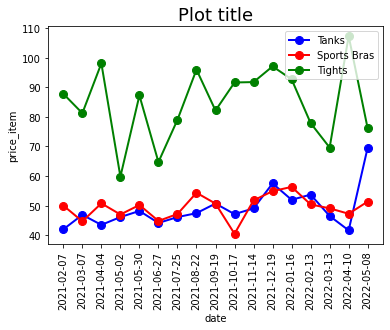

<Figure size 640x480 with 0 Axes>

   2021-02-07  2021-03-07  2021-04-04  2021-05-02  2021-05-30  2021-06-27  \
0   42.071263   46.954783   43.571714   46.198353   48.269262   44.221489   
1   50.082054   44.768462   50.826519   47.067647   50.273125   44.892273   
2   87.781587   81.227273   98.030202   59.831667   87.213333   64.755161   

   2021-07-25  2021-08-22  2021-09-19  2021-10-17  2021-11-14  2021-12-19  \
0   46.191923   47.522043   50.757396   47.193725   49.125227   57.552462   
1   47.234167   54.400597   50.742128   40.562703   51.824630   54.941296   
2   78.999667   95.926829   82.141429   91.592593   91.720233   97.015397   

   2022-01-16  2022-02-13  2022-03-13  2022-04-10  2022-05-08  最後一周的變化率  
0   52.024642   53.772338   46.567455   41.719583   69.653982  0.669575  
1   56.374488   50.465882   49.146103   47.317285   51.420603  0.086719  
2   92.659739   77.898551   69.639344  107.223621   76.085106 -0.290407  


In [21]:
# Settings
# sport = 'Training & Gym'
time_type = 'new' # new
last_time = '2022-05-08'
times = 17 #重複上述週期幾次
time_range = 4 # week 幾周量的新品
proportion_filter = {}#{'Feature':'結構性透氣','Category':'Leggings & Tights'} # {'Category':'Leggings & Tights'}
proportion_groupBy = 'Category'
pie_num = 5
line_num = 3
plot_filter = ['Tanks','Sports Bras','Tights']
get_price_lineplot(time_type,time_range,times,last_time,proportion_filter,proportion_groupBy, line_num, plot_filter)

# 製圖區

In [22]:
# 指定字體
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt

font_dirs = ['/usr/share/fonts/truetype/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
  font_manager.fontManager.addfont(font_file)

plt.rcParams['font.family'] = "Noto Sans Mono CJK TC"

No handles with labels found to put in legend.


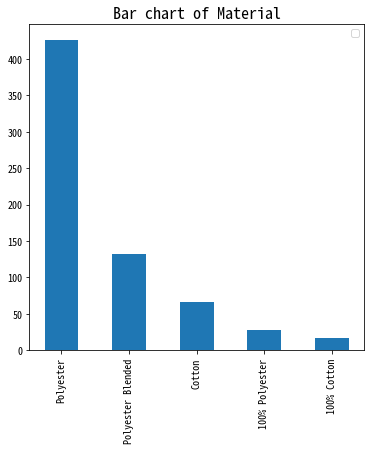

,Material,num,佔比
0,Polyester,425.916667,0.575045
1,Polyester Blended,131.916667,0.178105
2,Cotton,66.416667,0.089671
3,100% Polyester,28.333333,0.038254
4,100% Cotton,17.500000,0.023627
...,...,...,...
57,32% polyester,0.200000,0.000270
58,8% elastane,0.200000,0.000270
59,LINING: 60% polyester,0.166667,0.000225
60,SHELL: 60% polyester,0.166667,0.000225


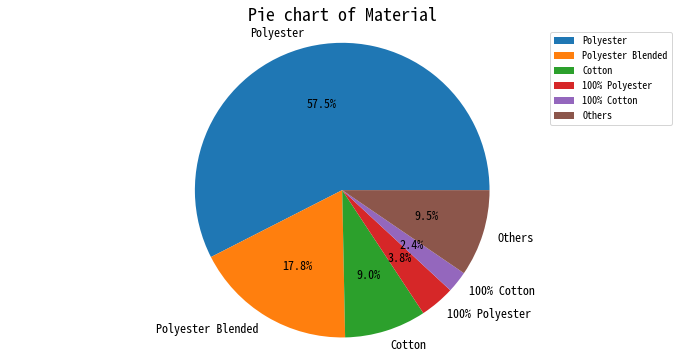

In [28]:
# Settings
# sport = 'Training & Gym'
time_type = 'new' # new
time = '2022-05-08'
time_range = 4 # week 幾周量的新品
proportion_filter = {}#{'Feature':'結構性透氣','Category':'Leggings & Tights'} # {'Category':'Leggings & Tights'}
proportion_groupBy = 'Material'
pie_num = 5
plot_filter = []

get_pie(time_type, time, time_range, proportion_filter, proportion_groupBy, pie_num, plot_filter, drop_spandex = True)

No handles with labels found to put in legend.


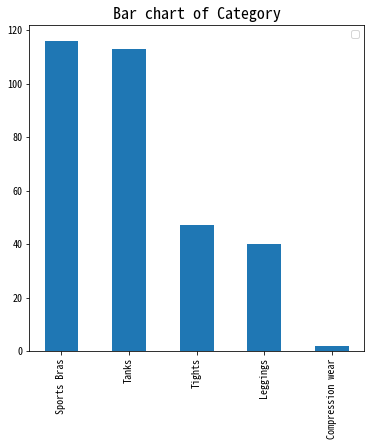

,Category,num,佔比
0,Sports Bras,116,0.364780
1,Tanks,113,0.355346
2,Tights,47,0.147799
3,Leggings,40,0.125786
4,Compression wear,2,0.006289


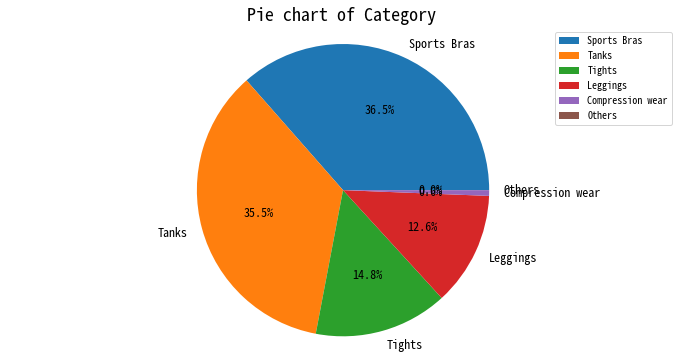

In [29]:
# Settings
# sport = 'Training & Gym'
time_type = 'new' # new
time = '2022-05-08'
time_range = 4 # week 幾周量的新品
proportion_filter = {}#{'Feature':'結構性透氣','Category':'Leggings & Tights'} # {'Category':'Leggings & Tights'}
proportion_groupBy = 'Category'
pie_num = 5
plot_filter = ['Tanks','Sports Bras','Tights','Leggings','Compression wear']

get_pie(time_type, time, time_range, proportion_filter, proportion_groupBy, pie_num, plot_filter, drop_spandex = True)

No handles with labels found to put in legend.


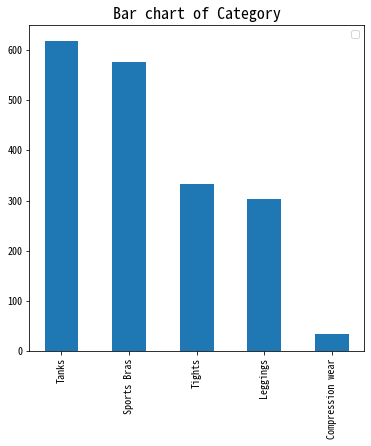

,Category,num,佔比
0,Tanks,618,0.331723
1,Sports Bras,576,0.309179
2,Tights,332,0.178207
3,Leggings,303,0.162641
4,Compression wear,34,0.018250


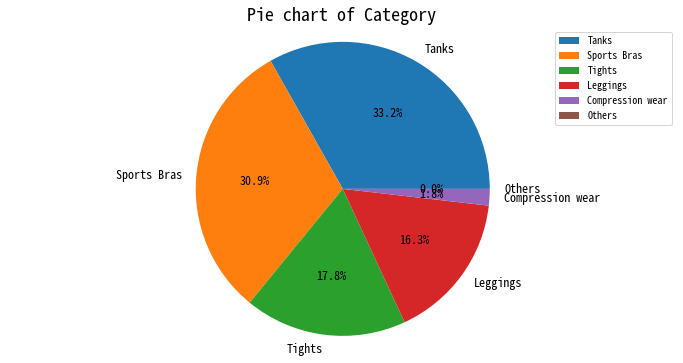

In [30]:
# Settings
# sport = 'Training & Gym'
time_type = 'market' # new
time = '2022-05-08'
time_range = 4 # week 幾周量的新品
proportion_filter = {}#{'Feature':'結構性透氣','Category':'Leggings & Tights'} # {'Category':'Leggings & Tights'}
proportion_groupBy = 'Category'
pie_num = 5
plot_filter = ['Tanks','Sports Bras','Tights','Leggings','Compression wear']

get_pie(time_type, time, time_range, proportion_filter, proportion_groupBy, pie_num, plot_filter, drop_spandex = True)

No handles with labels found to put in legend.


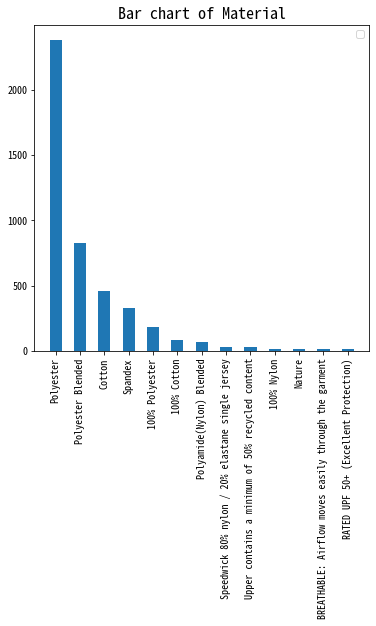

,Material,num,佔比
0,Polyester,2378.100000,0.492360
1,Polyester Blended,826.933333,0.171208
2,Cotton,461.016667,0.095449
3,Spandex,328.600000,0.068033
4,100% Polyester,186.533333,0.038620
...,...,...,...
220,POWERVITA. Innovative fabric gives a lighter t...,0.111111,0.000023
221,hugged&#45in feel,0.111111,0.000023
222,buttery soft and barely&#45there,0.111111,0.000023
223,4&#45way stretch for freedom of movement,0.111111,0.000023


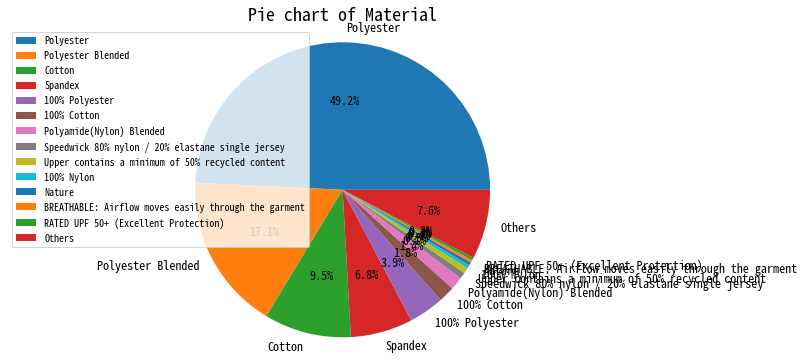

In [31]:
# Settings
# sport = 'Training & Gym'
time_type = 'market' # new
time = '2022-05-08'
time_range = 4 # week 幾周量的新品
proportion_filter = {}#{'Feature':'結構性透氣','Category':'Leggings & Tights'} # {'Category':'Leggings & Tights'}
proportion_groupBy = 'Material'
pie_num = 13
plot_filter = []

get_pie(time_type, time, time_range, proportion_filter, proportion_groupBy, pie_num, plot_filter)

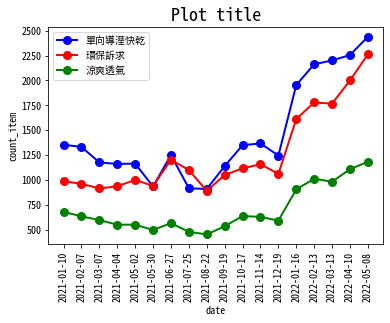

<Figure size 640x480 with 0 Axes>

In [32]:
time_type = 'market' # market
time_range = 4 # week 幾周量的新品
times = 18 #重複上述週期幾次
last_time = '2022-05-08'
proportion_filter = {}#{'Feature':'結構性透氣','Category':'Leggings & Tights'} # {'Category':'Leggings & Tights'}
proportion_groupBy = 'Feature' # Brand Material 'Category' 'AllMainColor'
line_num = 3
plot_filter = []

get_line_chart(time_type,time_range,times,last_time,proportion_filter,proportion_groupBy, line_num, plot_filter)

            Price        Price      Price
count  116.000000    40.000000   2.000000
mean    51.420603   520.474000  51.500000
std     12.130961  1074.042843   3.535534
min     21.990000    26.000000  49.000000
25%     45.000000    61.492500  50.250000
50%     52.000000    82.000000  51.500000
75%     58.000000   100.000000  52.750000
max     88.000000  3100.000000  54.000000


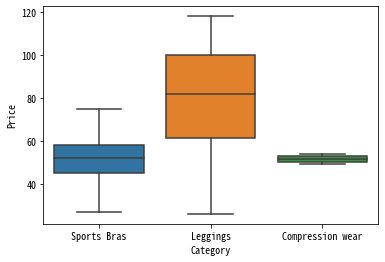

In [41]:
# Settings
# sport = 'Training & Gym'
time_type = 'new' # new
time = '2022-05-08'
time_range = 4 # week 幾周量的新品
proportion_filter = {}#{'Feature':'結構性透氣','Category':'Leggings & Tights'} # {'Category':'Leggings & Tights'}
proportion_groupBy = 'Category'
plot_filter = ['Sports Bras','Leggings','Compression wear']
get_price_boxplot(time_type, time, time_range, proportion_filter, proportion_groupBy, plot_filter,False)

            Price       Price      Price
count  646.000000  332.000000  48.000000
mean    48.926811   69.282139  54.555417
std     15.207261   27.593005  17.040936
min     17.990000   29.970000  24.970000
25%     35.000000   49.950000  42.990000
50%     52.000000   64.950000  54.485000
75%     59.000000   82.000000  69.950000
max     98.000000  140.000000  84.950000


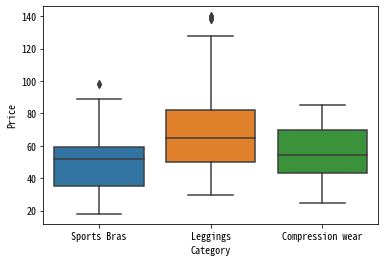

In [42]:
# Settings
# sport = 'Training & Gym'
time_type = 'market' # new
time = '2022-02-28'
time_range = 4 # week 幾周量的新品
proportion_filter = {}#{'Feature':'結構性透氣','Category':'Leggings & Tights'} # {'Category':'Leggings & Tights'}
proportion_groupBy = 'Category'
plot_filter = ['Sports Bras','Leggings','Compression wear']
get_price_boxplot(time_type, time, time_range, proportion_filter, proportion_groupBy, plot_filter)

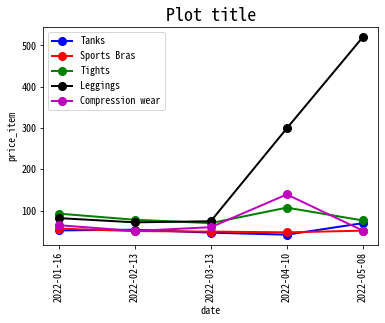

<Figure size 640x480 with 0 Axes>

   2022-01-16  2022-02-13  2022-03-13  2022-04-10  2022-05-08  最後一周的變化率
0   52.024642   53.772338   46.567455   41.719583   69.653982  0.669575
1   56.374488   50.465882   49.146103   47.317285   51.420603  0.086719
2   92.659739   77.898551   69.639344  107.223621   76.085106 -0.290407
3   81.858447   71.590000   74.175270  299.262222  520.474000  0.739190
4   64.686842   50.720526   59.800000  139.097187   51.500000 -0.629755


In [43]:
# Settings
# sport = 'Training & Gym'
time_type = 'new' # new
last_time = '2022-05-08'
times = 5 #重複上述週期幾次
time_range = 4 # week 幾周量的新品
proportion_filter = {}#{'Feature':'結構性透氣','Category':'Leggings & Tights'} # {'Category':'Leggings & Tights'}
proportion_groupBy = 'Category'
pie_num = 5
line_num = 3
plot_filter = ['Tanks','Sports Bras','Tights','Leggings','Compression wear']
get_price_lineplot(time_type,time_range,times,last_time,proportion_filter,proportion_groupBy, line_num, plot_filter)